<a href="https://colab.research.google.com/github/vicmcl/e-commerce/blob/main/notebook_essais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
from pathlib import Path
from google.colab import drive

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.flush_and_unmount()
drive.mount(str(drive_path))

Mounted at /content/drive


In [228]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

%matplotlib inline

In [265]:
plt.rcdefaults()
sns.set_style('whitegrid')
plt.rcParams["figure.dpi"] = 200

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False

plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.labelcolor'] = '#4C4C4C'
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.titlecolor'] = '#4C4C4C'
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.titlesize'] = 20

plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.color'] = "#89939C"
plt.rcParams['ytick.color'] = "#89939C"

plt.rcParams['xtick.labelcolor'] = "#89939C"
plt.rcParams['ytick.labelcolor'] = "#89939C"

In [115]:
# Load the dataset from the JSON file directly into a DataFrame
drive_project_dir = drive_path / 'MyDrive'/ 'OCR' / '4_Olist'
df = pd.read_json(drive_project_dir / 'data.json')
features = df[df.columns.tolist()]

# K-Means

In [116]:
models = dict() # Dict to keep track of all the models
inertia = []    # Dict to keep track of all the inertia of the models

# Try K values from 1 to 10
for i in range(1, 11):
    kmeans_model = KMeans(n_clusters=i, random_state=42)

    # Associate each data point with a cluster
    df[f'kmeans_{i}_cluster'] = kmeans_model.fit_predict(features)

    # Store model params
    inertia.append(kmeans_model.inertia_)
    models[i] = kmeans_model

## Elbow plot

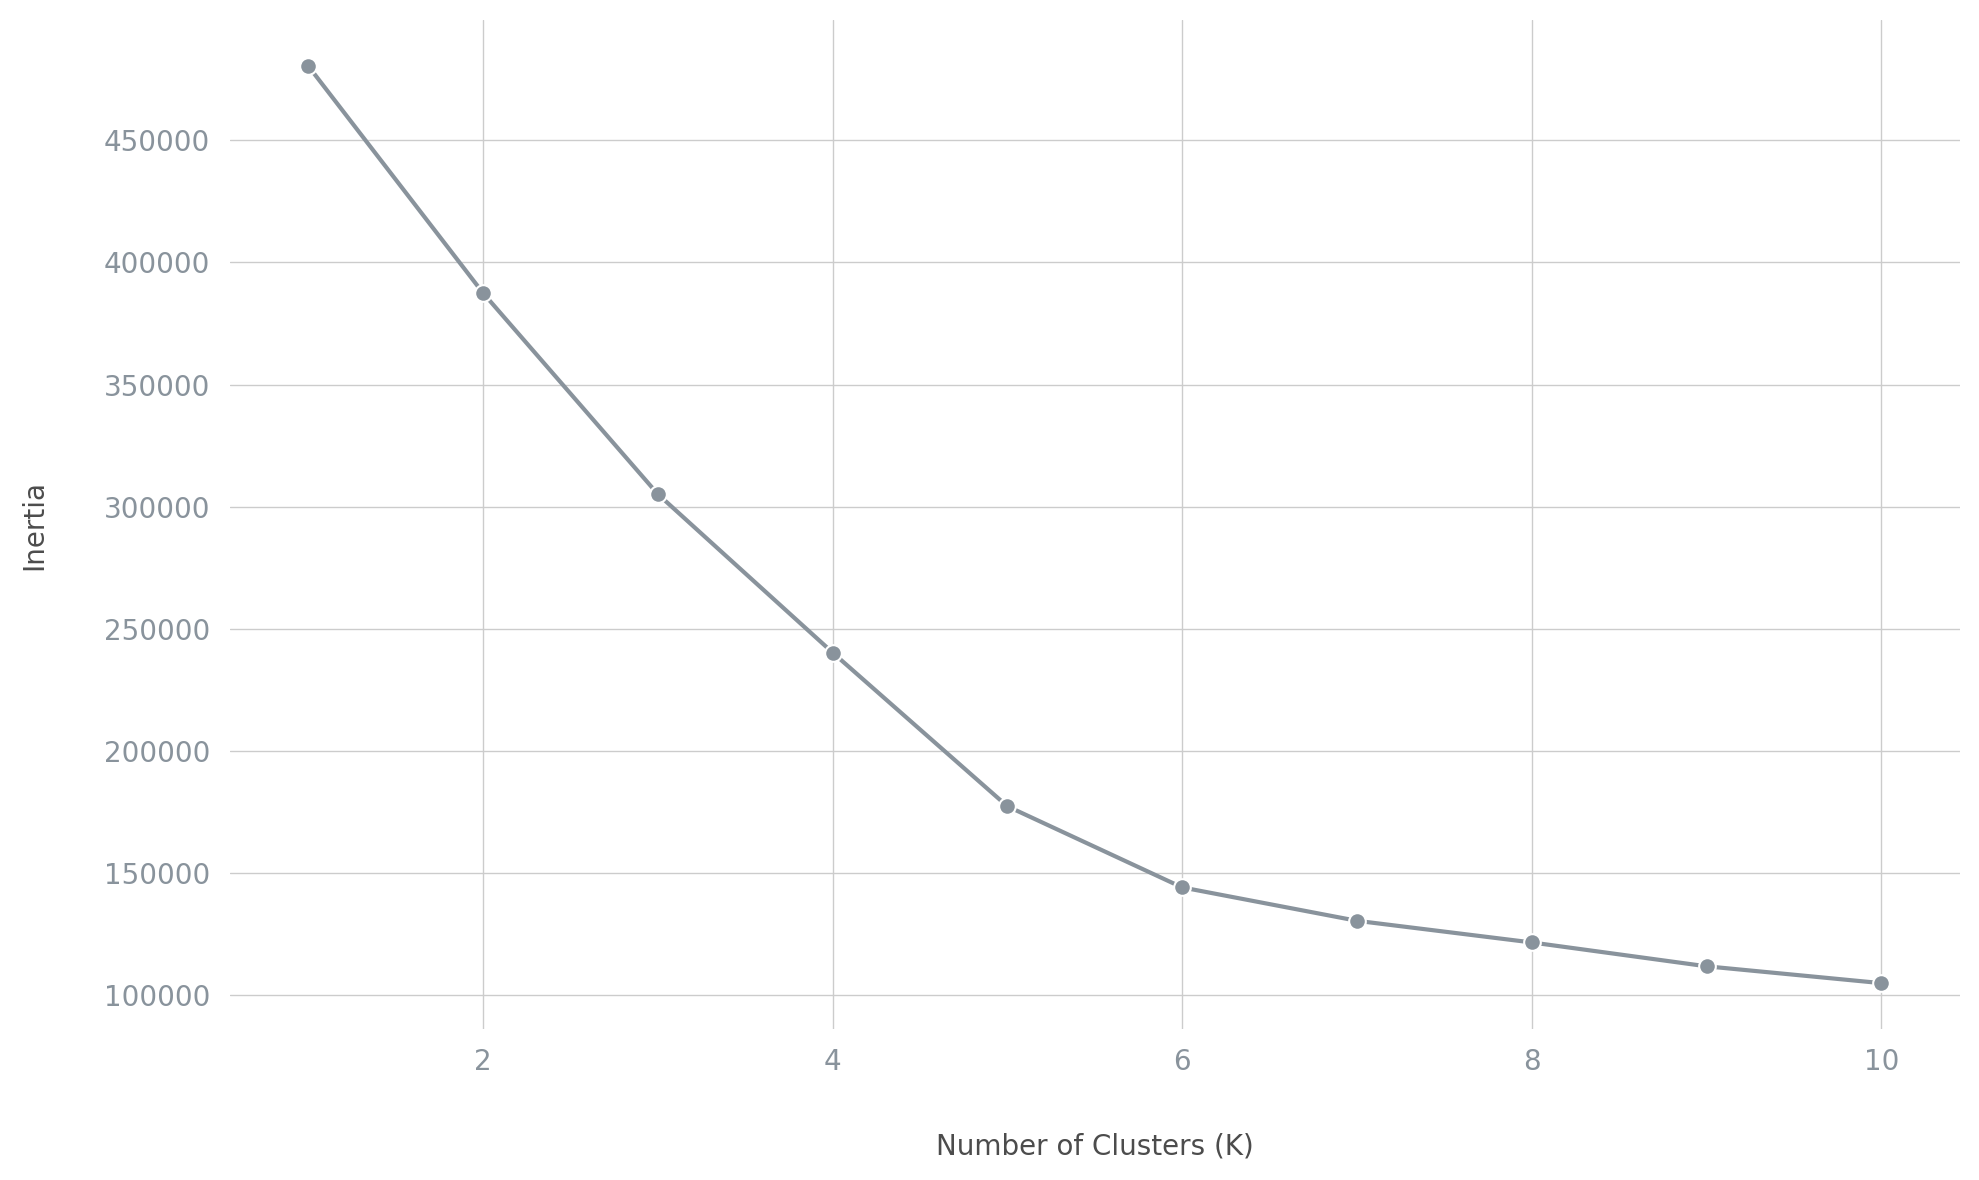

In [164]:
# Choose the K value from the "elbow" in the plot
sns.lineplot(x=range(1, 11), y=inertia, marker='o', color="#89939C")
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.tight_layout()

# Silhouette score and plot

In [128]:
# The value of 5 clusters is chosen
k = 5

# Sample 10000 points from features
subset_features = features.sample(n=10000, random_state=42)
subset_labels = df[f'kmeans_{k}_cluster'].loc[subset_features.index]

# Calculate the average silhouette score
silhouette_avg = silhouette_score(
    subset_features,
    subset_labels
)
print(
    f"Average silhouette score for K-Means with {k:} clusters:",
    f"{silhouette_avg:.5f}"
)

Average silhouette score for K-Means with 5 clusters: 0.31598


In [173]:
def silhouette_plot(clst, silhouette_vals, avg):
    """
    Create a plot for a silhouette analyssi of the clusters.

    Args:
        clst (np.array): array of cluster labels.
        sil_vals (np.array): silhouette coefficient of each data point.
        avg (float): average silhouette coefficient value
    """

    x_lower = 0
    x_tick_positions = []

    for i in range(5):
        # Sort the clusters by their label
        silhouette_cluster_i = silhouette_vals[clst == i]
        silhouette_cluster_i.sort()

        # Get the size of each cluster
        size_cluster_i = silhouette_cluster_i.shape[0]
        x_upper = x_lower + size_cluster_i

        # Fil the plot with plain color
        plt.fill_between(np.arange(x_lower, x_upper),
                          0, silhouette_cluster_i,
                          edgecolor="white", linewidth=2, )

        # Add the cluster labels
        x_tick_labels = range(clst.nunique())
        x_tick_positions.append(x_lower + size_cluster_i / 2)
        x_lower = x_upper

    plt.xlabel("Cluster label")
    plt.ylabel("Silhouette coefficient values")

    # Indicate the average silhouette score indicated with a dashed line
    plt.axhline(y=avg, color="#89939C", linestyle="--")
    plt.xticks(x_tick_positions, x_tick_labels)

    plt.tight_layout()

In [140]:
# Get silhouette coefficient for every data point
sample_silhouette_values = silhouette_samples(
    subset_features,
    subset_labels
)

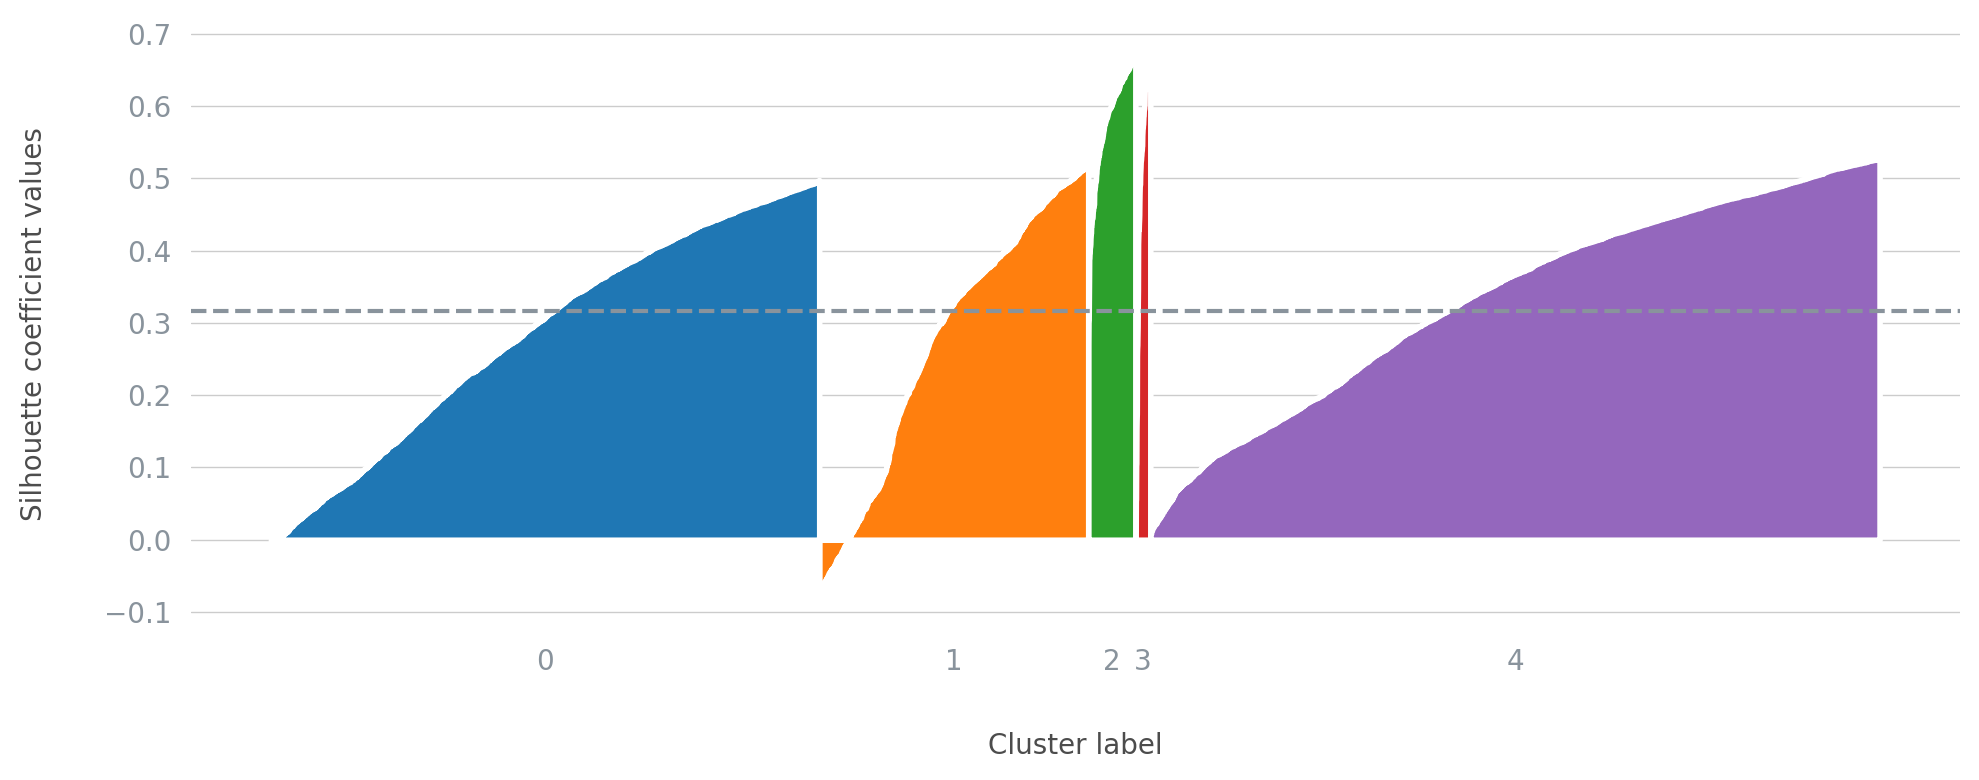

In [174]:
# Silhouette plot
fig = plt.figure(figsize=(10, 4))
silhouette_plot(
    subset_labels,
    sample_silhouette_values,
    silhouette_avg
)
plt.grid(axis='x', visible=False)

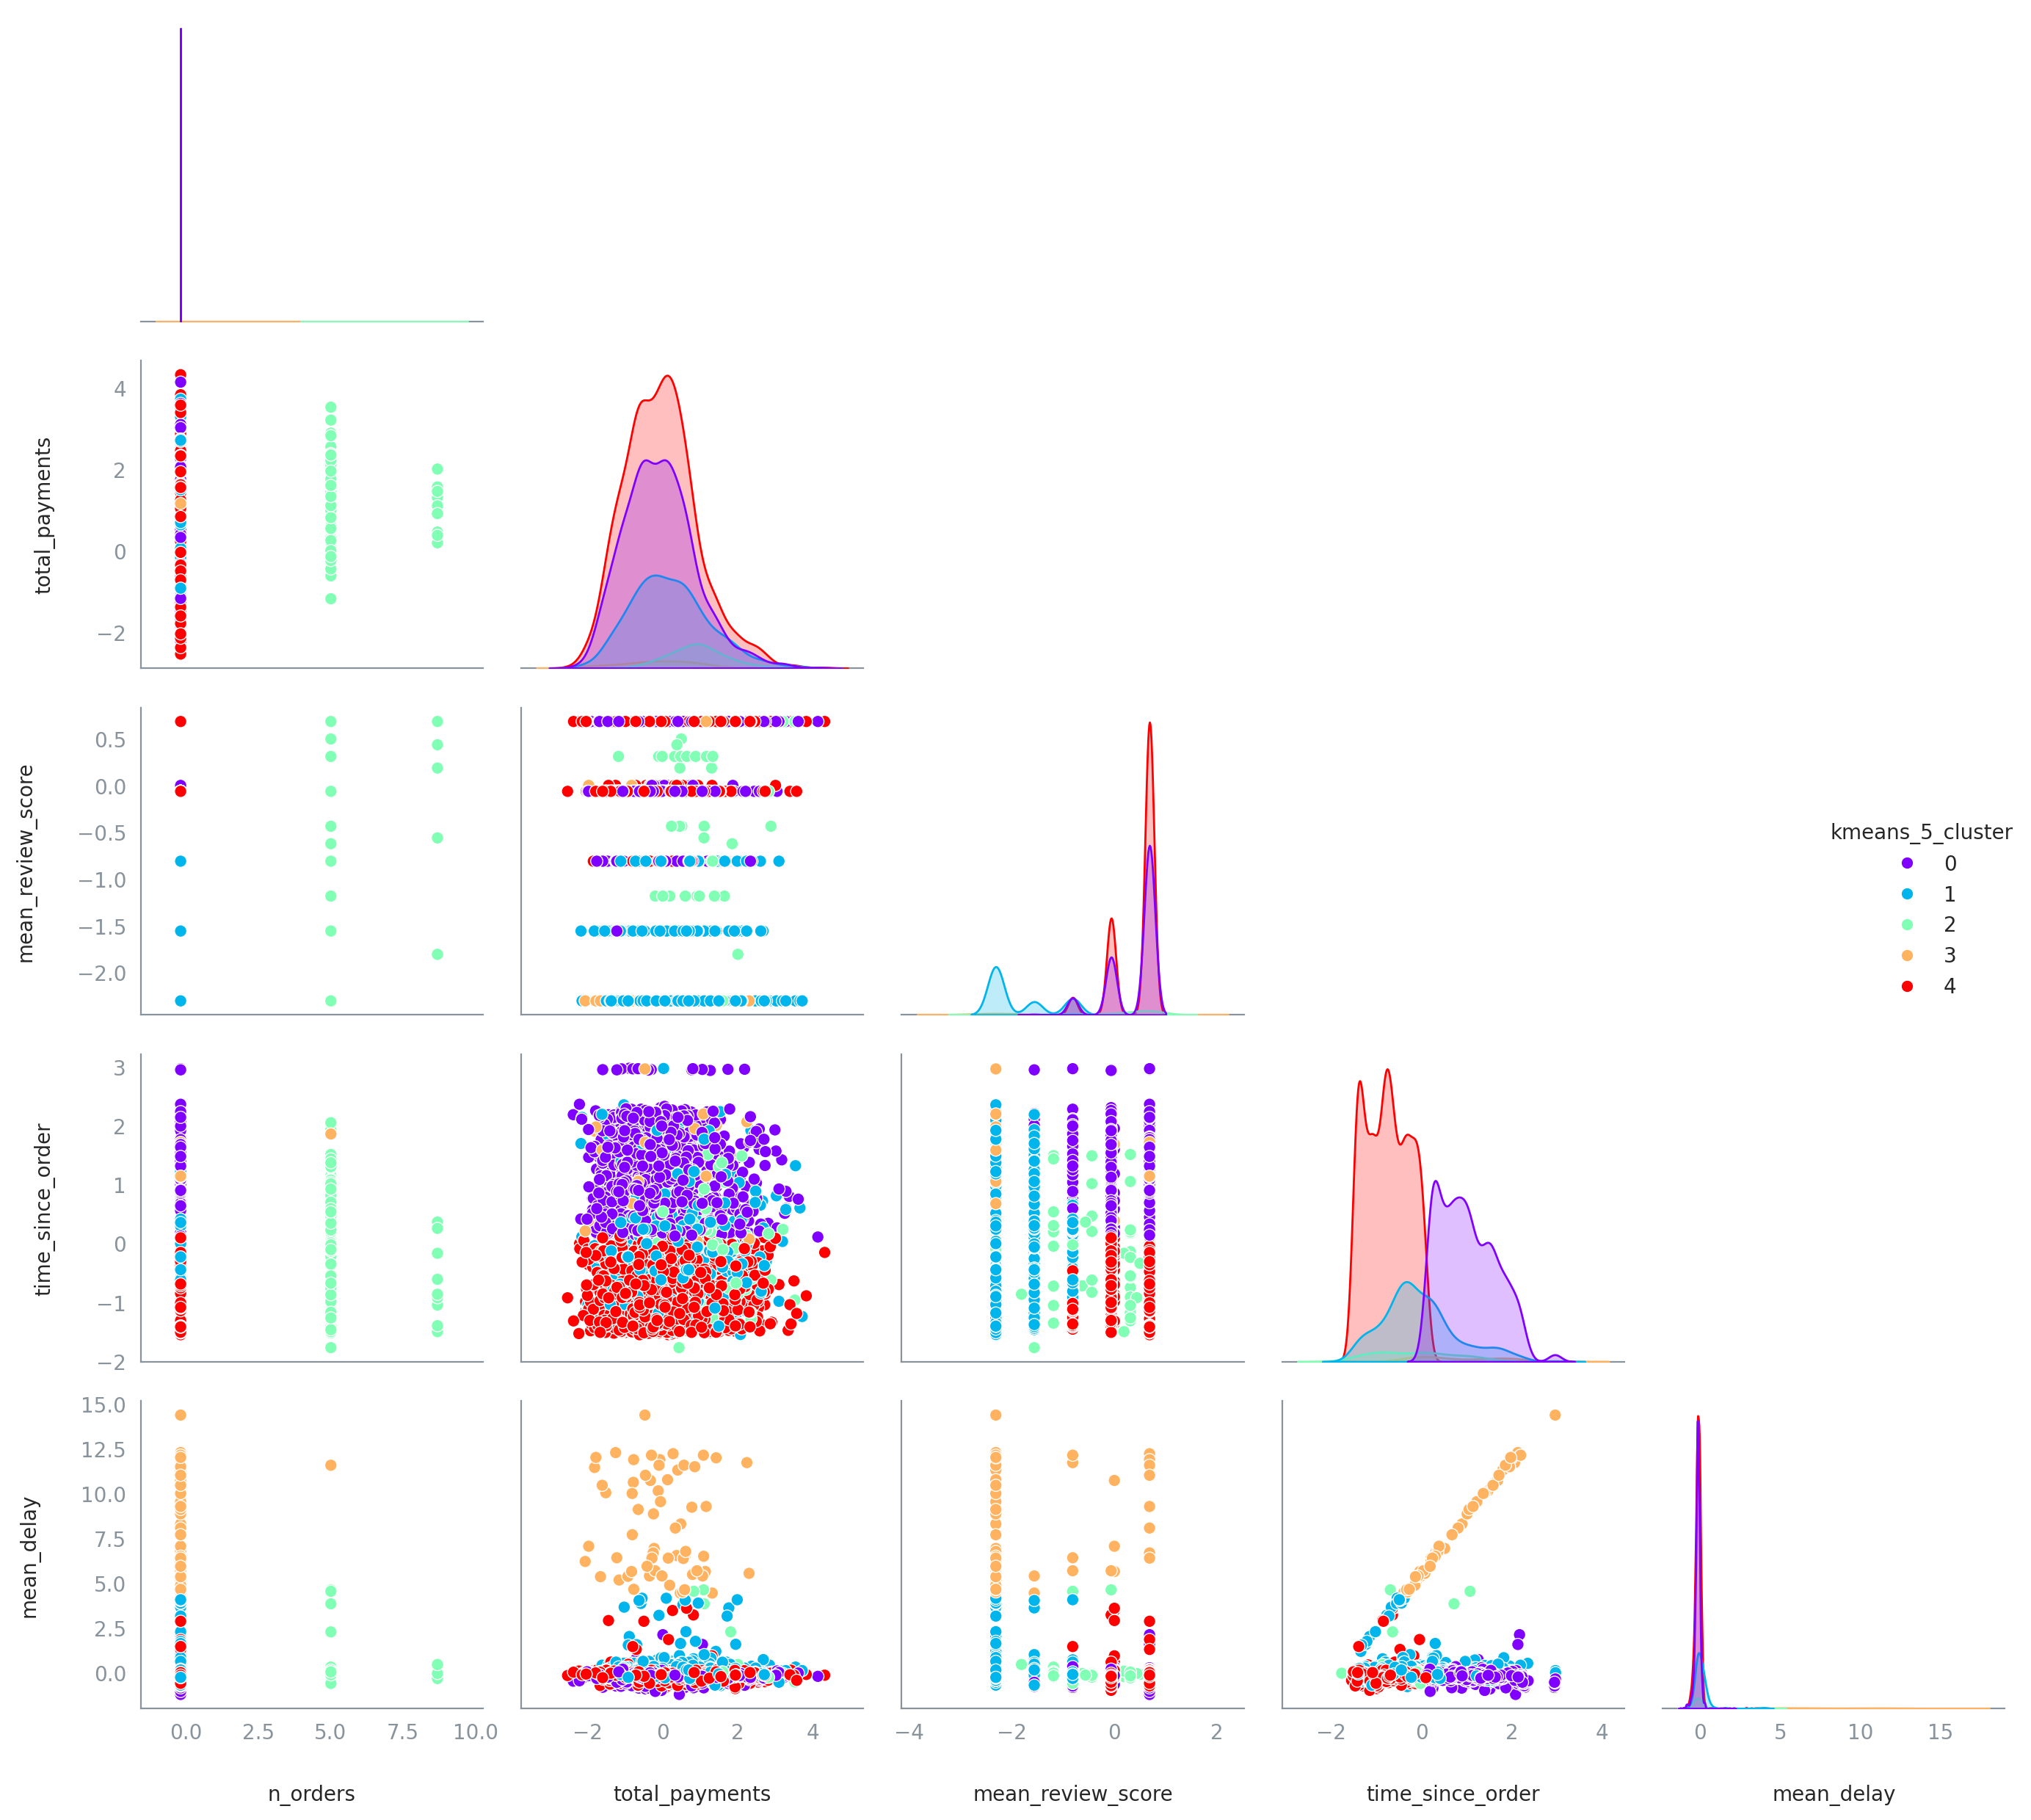

In [269]:
# Create a pairplot to analyse every pair of features
# and interpret the clusters, from 5000 sample points
sns.set_style('white')
cols = df.columns.tolist()[:len(features.columns)] + [f'kmeans_{k}_cluster']


g = sns.pairplot(
    df[cols].sample(5000),
    hue=f'kmeans_{k}_cluster',
    palette='rainbow',
    corner=True
)

for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['bottom'].set_color("#89939C")
        ax.spines['left'].set_color("#89939C")

plt.tight_layout()
sns.set_style('whitegrid')

### Observations
- Cluster 0: past clients, satisfied, no delay
- Cluster 1: clients dissatisfied with some delay
- Cluster 2: clients with multiple orders
- Cluster 3: clients with lost orders and long delay
- Cluster 4: recent clients, satisfied, no delay

# DBSCAN

In [193]:
# List of all the values taken by the params
param_grid = {
    'eps': [0.25, 0.5, 0.75, 1.0],
    'min_samples': [5, 10, 15, 20]
}

models_dbscan = dict()  # Dict to keep track of all the DBSCAN models
scores = dict()         # Dict to keep track of all the silhouette scores

# Test every combination of (eps, min_samples)
for (eps, min_samples) in list(
    product(param_grid['eps'], param_grid['min_samples'])
):

    # Initialize the DBSCAN model with the current set of params
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

    # Create the clusters and calculate the corresponding silhouette score
    df[f'dbscan_eps_{eps}_ms_{min_samples}'] = dbscan.fit_predict(features)
    score = silhouette_score(
        features,
        df[f'dbscan_eps_{eps}_ms_{min_samples}']
    )

    # Verbose
    print("Eps =", eps, "Min_samples =", min_samples)
    print("Silouette Score =", score)
    print(
        "N clusters :",
        len(df[f'dbscan_eps_{eps}_ms_{min_samples}'].value_counts())
    )
    print(
        "Biggest cluster",
        df[f'dbscan_eps_{eps}_ms_{min_samples}'].value_counts().iloc[0],
        "elements"
    )
    print("-------------------------------------------")

Eps = 0.25 Min_samples = 5
Silouette Score = -0.013667983239312818
N clusters : 100
Biggest cluster 52752 elements
-------------------------------------------
Eps = 0.25 Min_samples = 10
Silouette Score = -0.012162503061265153
N clusters : 38
Biggest cluster 52686 elements
-------------------------------------------
Eps = 0.25 Min_samples = 15
Silouette Score = -0.02871678944924811
N clusters : 20
Biggest cluster 52635 elements
-------------------------------------------
Eps = 0.25 Min_samples = 20
Silouette Score = 0.0002760435549216549
N clusters : 13
Biggest cluster 52554 elements
-------------------------------------------
Eps = 0.5 Min_samples = 5
Silouette Score = -0.06542664514446002
N clusters : 44
Biggest cluster 92064 elements
-------------------------------------------
Eps = 0.5 Min_samples = 10
Silouette Score = 0.22083363599342118
N clusters : 11
Biggest cluster 91964 elements
-------------------------------------------
Eps = 0.5 Min_samples = 15
Silouette Score = 0.228900

# Heatmaps

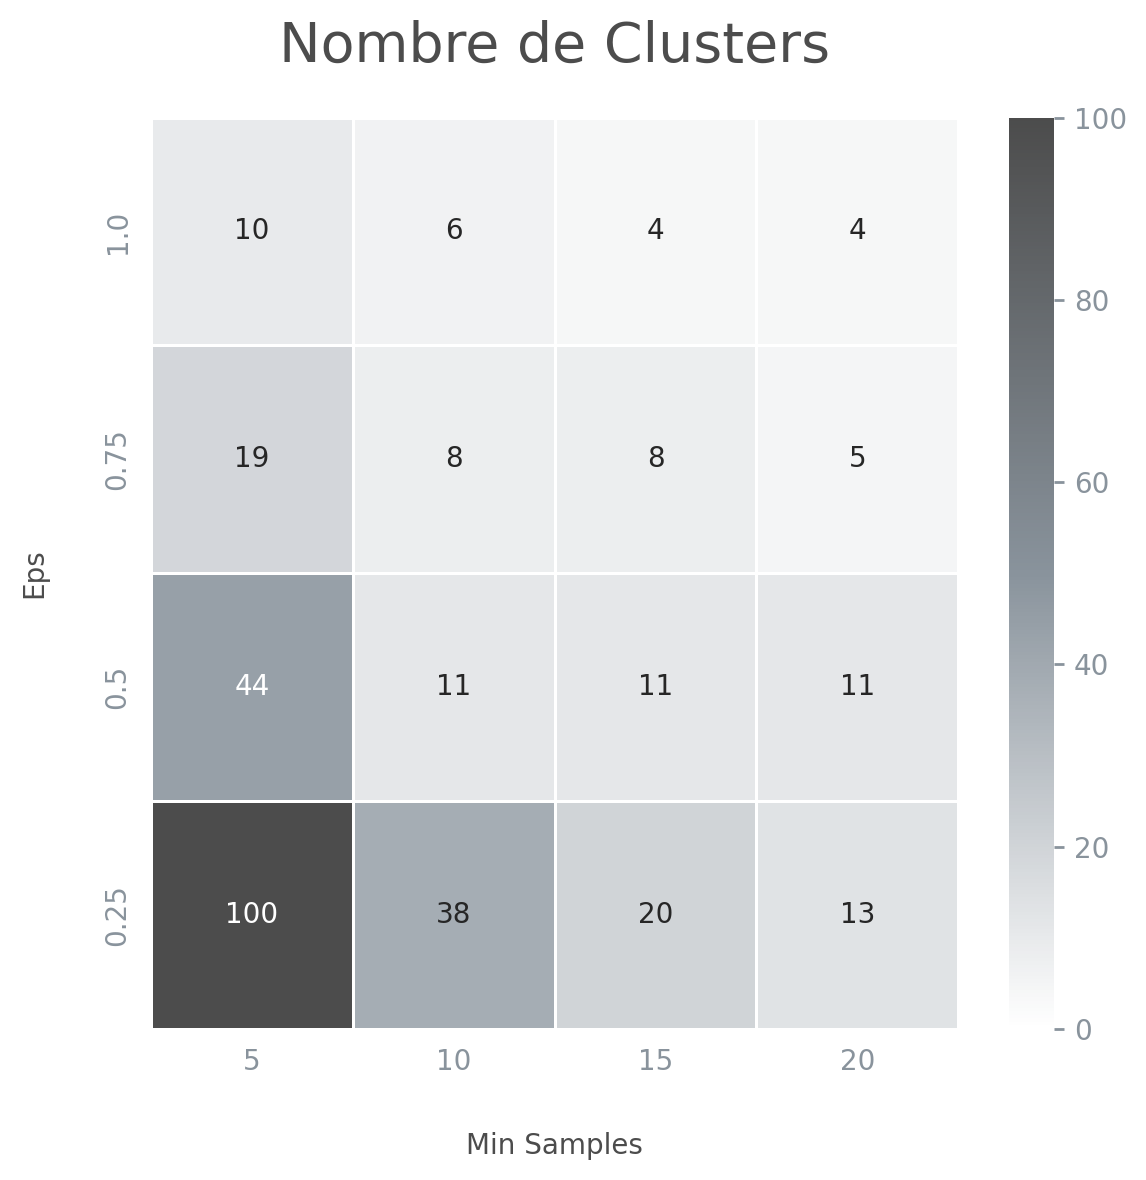

In [268]:
# Heatmap n clusters
plt.figure(figsize=(6, 6))

# Custom gradient
colors = ['#FFFFFF', '#89939C', "#4C4C4C"]
cmap = LinearSegmentedColormap.from_list('custom', colors)

data_hm = pd.DataFrame()

for (eps, min_sample), val in models_dbscan.items():
    data_hm.loc[eps, min_sample] = len(np.unique(val.labels_))

data_hm = data_hm.iloc[::-1].astype(int)
sns.heatmap(
    data_hm,
    cmap=cmap,
    annot=True,
    linewidths=0.5,
    vmin=0,
    linecolor='white',
    fmt="d"
)
plt.xlabel("Min Samples")
plt.ylabel("Eps")
plt.title("Nombre de Clusters")
plt.tight_layout()

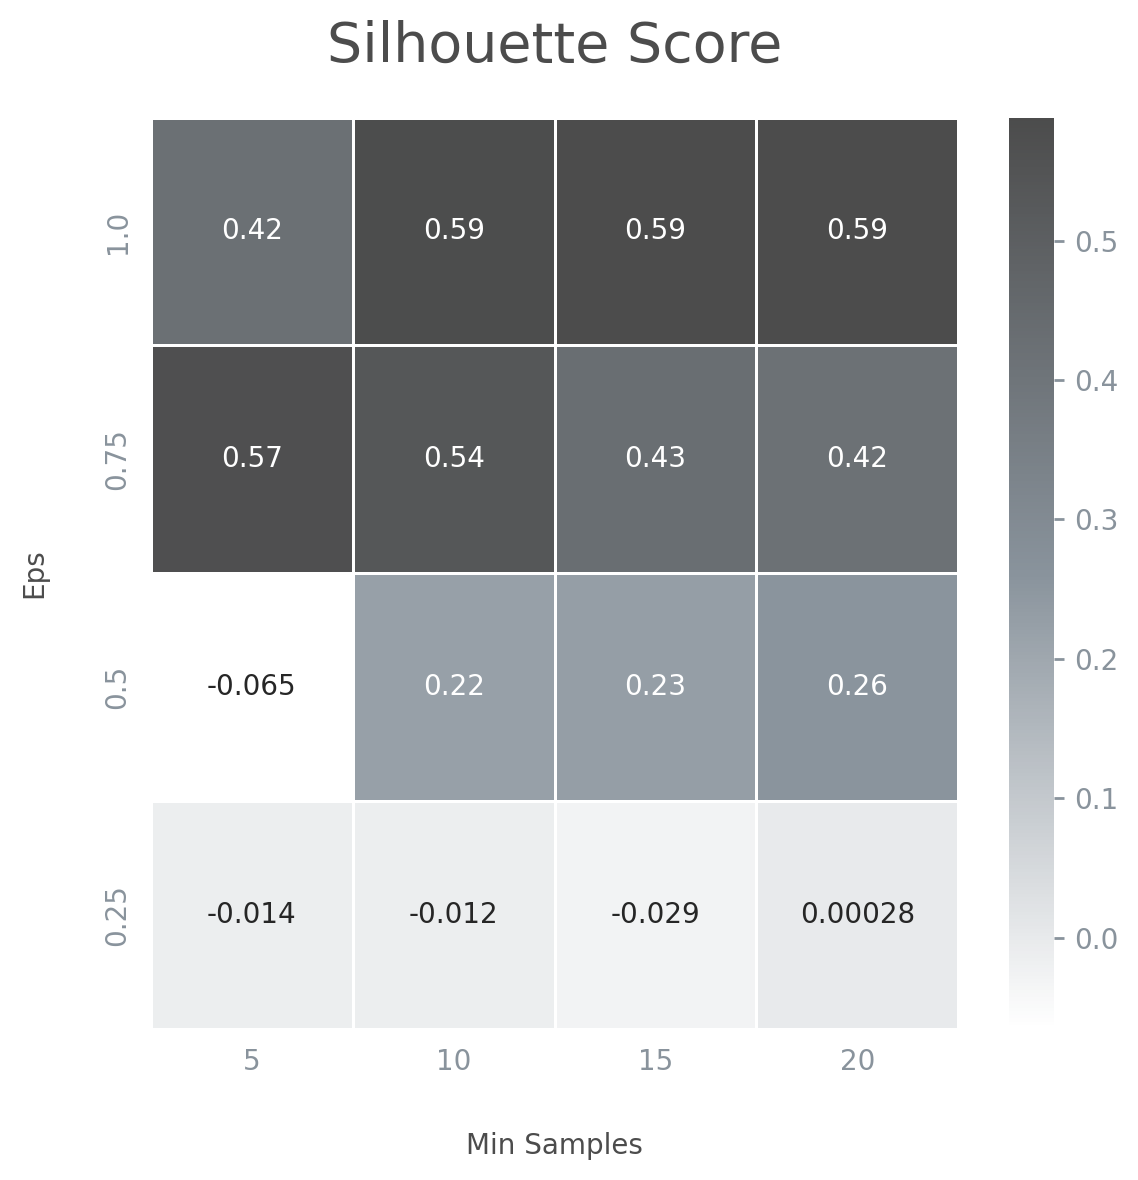

In [267]:
# Heatmap silhouette score
plt.figure(figsize=(6, 6))

data_hm = pd.DataFrame()

for (eps, min_sample), val in models_dbscan.items():
    data_hm.loc[eps, min_sample] = scores[(eps, min_sample)]

data_hm = data_hm.iloc[::-1]
sns.heatmap(
    data_hm,
    cmap=cmap,
    annot=True,
    linewidths=0.5,
    linecolor='white'
)
plt.xlabel("Min Samples")
plt.ylabel("Eps")
plt.title("Silhouette Score")
plt.tight_layout()